In [1]:
import os
os.environ["PYTHONHASHSEED"] = "42"


import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras import layers, regularizers, models
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import random
import numpy as np
import wandb
from wandb.integration.keras import WandbMetricsLogger


In [2]:
# sets up the random seed for reproduceability following guide here: https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  tf.random.set_seed(seed)
  
  print(f"Random seed set as {seed}")


set_seed(42)




Random seed set as 42


In [8]:
# Load the saved datasets

# 32x32x3
#train_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_32x32x3/train')
#val_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_32x32x3/validation')
#test_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_32x32x3/test')


# 96x96x3
#train_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3/train')
#val_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3/validation')
#test_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3/test')

# 96x96x3 batch 64
train_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3_batch64/train')
val_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3_batch64/validation')
test_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3_batch64/test')

# 96x96x3 batch 128
#train_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3_batch128/train')
#val_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3_batch128/validation')
#test_dataset = tf.data.Dataset.load('Data_TF_saved_cnn_96x96x3_batch128/test')


final_train_dataset = train_dataset.concatenate(val_dataset)
final_eval_dataset = final_train_dataset.shuffle(buffer_size=10000).prefetch(tf.data.AUTOTUNE)


num_classes = 14

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    #layers.RandomContrast(0.4),
    layers.RandomTranslation(0.10, 0.10),
    layers.RandomBrightness(0.1, value_range=(0, 1))
])

batch_images, batch_labels = next(iter(train_dataset))
original_image = batch_images[4]


original_image_np = original_image.numpy()

augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
augmented_image_np = augmented_image[0].numpy()
print(augmented_image_np)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))


axes[0].imshow(original_image_np)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(augmented_image_np)
axes[1].set_title("Augmented")
axes[1].axis("off")

plt.tight_layout()
plt.show()



In [33]:
class_weights = {
    0: 2.985006247396918,
    1: 0.7715577564861664,
    2: 0.9802366135539903,
    3: 2.4611950549450547,
    4: 2.748609779482263,
    5: 10.721017202692595,
    6: 1.1288391872735863,
    7: 1.5947930574098799,
    8: 3.340480074574691,
    9: 0.19894241578881625,
    10: 0.5672338741590819,
    11: 0.6494495038738616,
    12: 4.079112122936825,
    13: 10.137199434229137
}


In [ ]:
# resNet-9 like model

def residual_block(inputs, filters, stride=1, weight_decay=0.0001, dropout_rate=0.4):
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False, kernel_regularizer=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_regularizer=None)(x)
    x = layers.BatchNormalization()(x)
    
    #x = layers.Dropout(dropout_rate)(x)
    
    #projection
    if stride != 1 or inputs.shape[-1] != filters:
        skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_regularizer=None)(inputs)
        skip = layers.BatchNormalization()(skip)
    else:
        skip = inputs
    
    x = layers.Add()([x, skip])
    x = layers.ReLU()(x)
    return x
    
    
    
    
def create_resnet_v1(weight_decay=0.0001, dropout_rate=0.4):
    #input shape
    input_shape = (96, 96, 3)
    inputs = layers.Input(shape=input_shape)
    
    #augmentation
    x = data_augmentation(inputs, training=True)
    
    #initial conv layer
    x = layers.Conv2D(64, strides=2, kernel_size=7, padding='same', kernel_regularizer=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    
    # res stage 1
    x = residual_block(x, 64, stride=1, weight_decay=weight_decay, dropout_rate=dropout_rate)
    x = residual_block(x, 64, stride=1, weight_decay=weight_decay, dropout_rate=dropout_rate)

    
    # res stage 2
    x = residual_block(x, 128, stride=2, weight_decay=weight_decay, dropout_rate=dropout_rate)
    x = residual_block(x, 128, stride=1, weight_decay=weight_decay, dropout_rate=dropout_rate)

    
    # res stage 3
    x = residual_block(x, 256, stride=2, weight_decay=weight_decay, dropout_rate=dropout_rate)
    x = residual_block(x, 256, stride=1, weight_decay=weight_decay, dropout_rate=dropout_rate)

    
    # res stage 4
    x = residual_block(x, 512, stride=2, weight_decay=weight_decay, dropout_rate=dropout_rate)
    x = residual_block(x, 512, stride=1, weight_decay=weight_decay, dropout_rate=dropout_rate)
  
    # avg pooling instead of flatten (apparently more used?)
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=None)(x)
    
    # group and return model
    model = tf.keras.Model(inputs, outputs)   
    return model 

model = create_resnet_v1(weight_decay=0.0001, dropout_rate=0.5)
model.summary()

In [25]:
# 1) Initialize W&B

wandb.init(
    project="CNN-test", 
    name="big aug3", 
    group="aug", 
    config={
        "seet": 42,
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 64,
        "dropout": 0.4,
        "image_size": 96,
        "batch_normalization": True,
        "flip": "vertical",
        "rotation": 0.05,
        "zoom": 0.1,
        "translation": (0.10, 0.10),
        "brightness": 0.1
    }
)


# 2) Create the ResNet model
model = create_resnet_v1()

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

"""early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)"""

history = model.fit(
    final_train_dataset,
    #validation_data=val_dataset,
    #class_weight=class_weights,
    epochs=20,
    batch_size=64,
    callbacks=[WandbMetricsLogger()]#, early_stopping]
)

#best_val_loss = min(history.history['val_loss'])
#wandb.log({"best_val_loss": best_val_loss})




# 5) Finish the W&B run
wandb.finish()

Epoch 1/20
506/506 [==============================] - 19s 36ms/step - loss: 2.0871 - accuracy: 0.3782
Epoch 2/20
506/506 [==============================] - 18s 35ms/step - loss: 1.6425 - accuracy: 0.4614
Epoch 3/20
506/506 [==============================] - 18s 35ms/step - loss: 1.5131 - accuracy: 0.4871
Epoch 4/20
506/506 [==============================] - 17s 34ms/step - loss: 1.3697 - accuracy: 0.5310
Epoch 5/20
506/506 [==============================] - 17s 33ms/step - loss: 1.2623 - accuracy: 0.5621
Epoch 6/20
506/506 [==============================] - 17s 34ms/step - loss: 1.1857 - accuracy: 0.5881
Epoch 7/20
506/506 [==============================] - 17s 34ms/step - loss: 1.0960 - accuracy: 0.6173
Epoch 8/20
506/506 [==============================] - 17s 34ms/step - loss: 1.0199 - accuracy: 0.6435
Epoch 9/20
506/506 [==============================] - 17s 34ms/step - loss: 0.9541 - accuracy: 0.6645
Epoch 10/20
506/506 [==============================] - 18s 35ms/step - loss: 0.898

epoch/accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch/accuracy,0.79096
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.567


SWEEP FOR LR AND OPTIMIZER

In [ ]:
sweep_config = {
    'method': 'grid',
    'name': 'ResNet_optimizer_sweep3',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'optimizer_config': {
            'values': [
                {'optimizer': 'SGD', 'momentum': 0.9},
                {'optimizer': 'SGD', 'momentum': 0.95},
                {'optimizer': 'SGD', 'momentum': 0.99},
                {'optimizer': 'Adam', 'momentum': 0.0}
            ]
        },
        'learning_rate': {
            'values': [0.000100, 0.000250, 0.000500, 0.001000, 0.002500, 0.005000, 0.010000, 0.025000]
        },
        'epochs': {
            'value': 40
        },
        'batch_size': {
            'value': 64
        },
        'image_size': {
            'value': 96
        }
    }
}



# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="CNN-test")

def train():
    wandb.init()
    
    model = create_resnet_v1()
    
    optimizer_config = wandb.config.optimizer_config

    if optimizer_config['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=wandb.config.learning_rate,
            momentum=optimizer_config['momentum']
        )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=wandb.config.epochs,
        batch_size=wandb.config.batch_size,
        callbacks=[WandbMetricsLogger(), early_stopping]
    )
    
    best_val_loss = min(history.history['val_loss'])

    wandb.log({"best_val_loss": best_val_loss})

    wandb.finish()



wandb.agent(sweep_id, train, count=640)


Transfer learning part

In [8]:
wandb.init(
    project="final_eval",
    name="resnet50_final_eval",
    config={
        "epochs_phase1": 3,
        "epochs_phase2": 3,
        "learning_rate_phase1": 1e-3,
        "learning_rate_phase2": 1e-5,
        "unfreeze_layers": 20
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: awacherfuglsang (awacherfuglsang-university-of-southern-denmark). Use `wandb login --relogin` to force relogin


In [ ]:
# resize and 'unnormalize' image
def resize_to_224(image, label):
    image = tf.image.resize(image, [224, 224])
    image = image * 255.0
    return image, label

# Apply the resizing transformation
train_dataset = train_dataset.map(resize_to_224, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(resize_to_224, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(resize_to_224, num_parallel_calls=tf.data.AUTOTUNE)
final_train_dataset = train_dataset.concatenate(val_dataset)

# Optionally, for performance, prefetch batches
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.prefetch(tf.data.AUTOTUNE)

#for final eval
final_eval_dataset = final_train_dataset.shuffle(buffer_size=10000).prefetch(tf.data.AUTOTUNE)


In [28]:
# Get one batch from the dataset
sample_batch = next(iter(final_train_dataset))

# Extract one image and label
sample_image, sample_label = sample_batch

# Print the shape and pixel range
print("Image shape:", sample_image.shape)
print("Min pixel value:", tf.reduce_min(sample_image).numpy())
print("Max pixel value:", tf.reduce_max(sample_image).numpy())


Image shape: (64, 224, 224, 3)
Min pixel value: 0.0
Max pixel value: 255.0


In [ ]:

num_classes = 14

# Load the base ResNet50 model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)


model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                28686 

In [10]:
# Train
history = model.fit(
    final_train_dataset,
    epochs=3,
    #validation_data=val_dataset,
    #class_weight=class_weights,
    callbacks=[WandbMetricsLogger()]
)

Epoch 1/3
506/506 [==============================] - 66s 113ms/step - loss: 0.8985 - accuracy: 0.6914
Epoch 2/3
506/506 [==============================] - 57s 112ms/step - loss: 0.6714 - accuracy: 0.7600
Epoch 3/3
506/506 [==============================] - 57s 113ms/step - loss: 0.6077 - accuracy: 0.7813


In [68]:
base_model.trainable = True

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history2 = model.fit(
    final_train_dataset,
    epochs=3,
    #validation_data=val_dataset,
    #class_weight=class_weights,
    callbacks=[WandbMetricsLogger()]
)


=== Model summary (partially unfrozen) ===
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)    

In [ ]:
base_model.trainable = True

# Recompile with further lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history3 = model.fit(
    final_train_dataset,
    epochs=3,
    #validation_data=val_dataset,
    #class_weight=class_weights,
    callbacks=[WandbMetricsLogger()]
)

=== Model summary (partially unfrozen) ===
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                                 
Total params: 23,616,398
Trainable params: 23,563,278
Non-trainable params: 

In [ ]:
# clf raport
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
report = classification_report(y_true, y_pred)
print(report)

58/58 [==============================] - 7s 114ms/step
              precision    recall  f1-score   support

           0       0.44      0.48      0.46        88
           1       0.69      0.77      0.73       333
           2       0.54      0.53      0.54       262
           3       0.94      0.92      0.93       111
           4       0.99      0.90      0.94        99
           5       0.42      0.20      0.27        25
           6       0.98      0.96      0.97       239
           7       0.95      0.98      0.97       170
           8       0.99      0.95      0.97        81
           9       0.86      0.84      0.85      1288
          10       0.61      0.64      0.63       453
          11       0.95      0.97      0.96       424
          12       0.59      0.38      0.46        64
          13       0.78      0.54      0.64        26

    accuracy                           0.80      3663
   macro avg       0.76      0.72      0.74      3663
weighted avg       0.80  

In [104]:
wandb.finish()

epoch/accuracy,▁▃▄▅▆▆▇██
epoch/epoch,▁▅█▁▅█▁▅█
epoch/learning_rate,███▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▁▁▁
epoch/val_accuracy,▁▃▄▆▆▆▇██
epoch/val_loss,█▅▄▂▁▁▁▁▁
epoch/accuracy,0.91572
epoch/epoch,2
epoch/learning_rate,0.0
epoch/loss,0.25523
epoch/val_accuracy,0.81046


In [50]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:

for image, label in train_dataset.unbatch().take(1):  
    image = tf.squeeze(image).numpy()
    label = label.numpy()
    
    #normalize
    image = image/255

    # Display the image
    plt.imshow(image)
    plt.axis("off")  # Hide axis
    plt.title(f"Label: {label}")
    plt.show()

In [134]:
layer_name = 'conv4_block6_out'

activation_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(layer_name).output
)

In [135]:
for image, label in train_dataset.unbatch().take(1):
    image = tf.expand_dims(image, axis=0)
    label = label.numpy()


In [136]:
image_tensor = preprocess_input(image)
image_tensor

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[ 53.060997,  41.221   ,  33.32    ],
         [ 52.63244 ,  40.792442,  33.177147],
         [ 51.346718,  39.50672 ,  32.748573],
         ...,
         [102.91816 ,  90.07816 ,  83.17716 ],
         [106.77534 ,  93.93534 ,  87.03434 ],
         [108.061   ,  95.221   ,  88.32    ]],

        [[ 52.346718,  40.50672 ,  32.748573],
         [ 51.95896 ,  40.139366,  32.646523],
         [ 50.795708,  39.037346,  32.340416],
         ...,
         [103.91816 ,  91.07816 ,  84.17716 ],
         [107.77534 ,  94.93534 ,  88.03434 ],
         [109.061   ,  96.221   ,  89.32    ]],

        [[ 50.203865,  38.36387 ,  31.034294],
         [ 49.93856 ,  38.1802  ,  31.05471 ],
         [ 49.14263 ,  37.629158,  31.115929],
         ...,
         [106.91816 ,  94.07816 ,  87.17716 ],
         [110.77534 ,  97.93534 ,  91.03434 ],
         [112.061   ,  99.221   ,  92.32    ]],

        ...,

        [[-28.51043 , -39.350426, 

In [137]:

activations = activation_model(image_tensor)

print("Shape of activation maps:", activations.shape)

Shape of activation maps: (1, 14, 14, 1024)


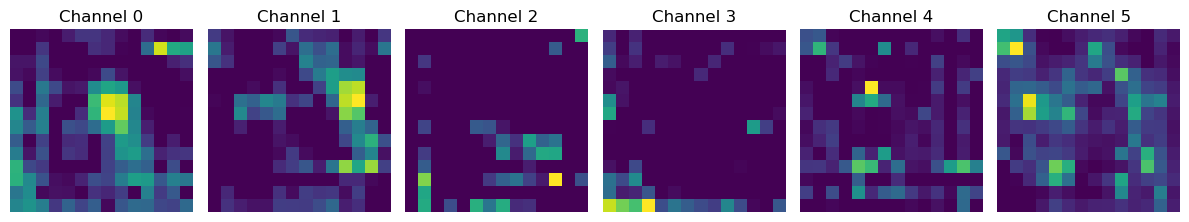

In [ ]:

activation_maps = activations[0]

num_channels_to_show = 6
plt.figure(figsize=(12, 6))

for i in range(0, num_channels_to_show):
    ax = plt.subplot(1, num_channels_to_show, i+1)
    channel_image = activation_maps[..., i].numpy()

    plt.imshow(channel_image)
    plt.title(f'Channel {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()